In [1]:

! pip3 install transformers
import pandas as pd
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime
import torch
import csv
import transformers
import torch.nn as nn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.1 MB/s eta 0:00:00


In [2]:

def tokenize_and_format(sentences):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [3]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [4]:
# import pandas as pd
# data = pd.read_csv('song_lyrics.csv')
# lyrics = data['lyrics']
# labels = data['label']
# df = data.sample(frac=1)
# df = df.sample(frac=1)
# print(df.head(10))

In [6]:

df = pd.read_csv('song_lyrics.csv')
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

texts = df.lyrics.values
labels = df.label.values
labels = labels.tolist()


### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(texts)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
# print('Original: ', texts[0])
# print('Token IDs:', input_ids[0])

In [7]:
total = len(df)

num_train = int(total * .8)
num_val = int(total * .1)
num_test = total - num_train - num_val

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train)]
val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train, num_val+num_train)]
test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_val + num_train, total)]


train_text = [texts[i] for i in range(num_train)]
val_text = [texts[i] for i in range(num_train, num_val+num_train)]
test_text = [texts[i] for i in range(num_val + num_train, total)]

In [8]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:

batch_size = 16
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    total_correct = 0

    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        #print(pred_flat)
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct

        #print(batch)
        # print(pred_flat)
        # print(labels_flat)

        

        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)

    # print(batch)
    # print(pred_flat)
    # print(labels_flat)
    return avg_val_accuracy



In [12]:
import random
loss1 = []

# training loop

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    num_batches = int(len(train_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    loss1.append(total_train_loss)
    val_acc = get_validation_performance(val_set)
    print(f"Validation accuracy: {val_acc}")
    
print("")
print("Training complete!")



======== Epoch 1 / 10 ========
Training...
Total loss: 0.5081419742200524
Validation accuracy: 1.0

======== Epoch 2 / 10 ========
Training...
Total loss: 0.4896821607835591
Validation accuracy: 1.0

======== Epoch 3 / 10 ========
Training...
Total loss: 0.4587452585110441
Validation accuracy: 1.0

======== Epoch 4 / 10 ========
Training...
Total loss: 0.4606506708660163
Validation accuracy: 1.0

======== Epoch 5 / 10 ========
Training...
Total loss: 0.45348292868584394
Validation accuracy: 1.0

======== Epoch 6 / 10 ========
Training...
Total loss: 0.36278895987197757
Validation accuracy: 1.0

======== Epoch 7 / 10 ========
Training...
Total loss: 0.21294929791474715
Validation accuracy: 1.0

======== Epoch 8 / 10 ========
Training...
Total loss: 0.5219496835488826
Validation accuracy: 1.0

======== Epoch 9 / 10 ========
Training...
Total loss: 0.017439577699406072
Validation accuracy: 1.0

======== Epoch 10 / 10 ========
Training...
Total loss: 0.009972960222512484
Validation accura

In [13]:
get_validation_performance(test_set)

1.0

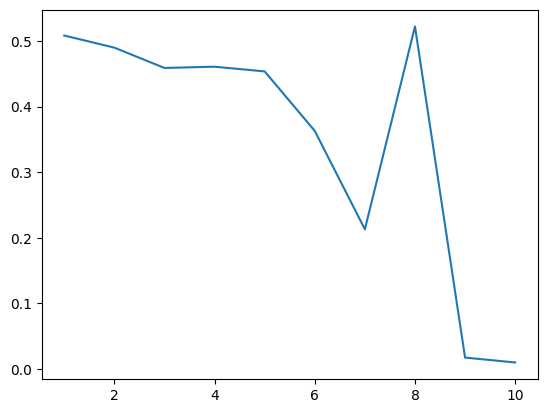

In [17]:
import matplotlib.pyplot as plt


epoc = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epoc,loss1)
plt.show()